In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import preprocessing
import lightgbm as lgb
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')
    
pd.options.display.max_columns = 500
#import pandas_profiling

    
    

In [2]:
train_df = pd.read_pickle('../data/train_df.pkl')
test_df = pd.read_pickle('../data/test_df.pkl')

In [3]:
var_list = [f'var_{i}' for i in range(200)]

## FE

In [4]:
test_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_freq,var_1_freq,var_2_freq,var_3_freq,var_4_freq,var_5_freq,var_6_freq,var_7_freq,var_8_freq,var_9_freq,var_10_freq,var_11_freq,var_12_freq,var_13_freq,var_14_freq,var_15_freq,var_16_freq,var_17_freq,var_18_freq,var_19_freq,var_20_freq,var_21_freq,var_22_freq,var_23_freq,var_24_freq,var_25_freq,var_26_freq,var_27_freq,var_28_freq,var_29_freq,var_30_freq,var_31_freq,var_32_freq,var_33_freq,var_34_freq,var_35_freq,var_36_freq,var_37_freq,var_38_freq,var_39_freq,var_40_freq,var_41_freq,var_42_freq,var_43_freq,var_44_freq,var_45_freq,var_46_freq,var_47_freq,var_48_freq,var_49_freq,var_50_freq,var_51_freq,var_52_freq,var_53_freq,var_54_freq,var_55_freq,var_56_freq,var_57_freq,var_58_freq,var_59_freq,var_60_freq,var_61_freq,var_62_freq,var_63_freq,var_64_freq,var_65_freq,var_66_freq,var_67_freq,var_68_freq,var_69_freq,var_70_freq,var_71_freq,var_72_freq,var_73_freq,var_74_freq,var_75_freq,var_76_freq,var_77_freq,var_78_freq,var_79_freq,var_80_freq,var_81_freq,var_82_freq,var_83_freq,var_84_freq,var_85_freq,var_86_freq,var_87_freq,var_88_freq,var_89_freq,var_90_freq,var_91_freq,var_92_freq,var_93_freq,var_94_freq,var_95_freq,var_96_freq,var_97_freq,var_98_freq,var_99_freq,var_100_freq,var_101_freq,var_102_freq,var_103_freq,var_104_freq,var_105_freq,var_106_freq,var_107_freq,var_108_freq,var_109_freq,var_110_freq,var_111_freq,var_112_freq,var_113_freq,var_114_freq,var_115_freq,var_116_freq,var_117_freq,var_118_freq,var_119_freq,var_120_freq,var_121_freq,var_122_freq,var_123_freq,var_124_freq,var_125_freq,var_126_freq,var_127_freq,var_128_freq,var_129_freq,var_130_freq,var_131_freq,var_132_freq,var_133_freq,var_134_freq,var_135_freq,var_136_freq,var_137_freq,var_138_freq,var_139_freq,var_140_freq,var_141_freq,var_142_freq,var_143_freq,var_144_freq,var_145_freq,var_146_freq,var_147_freq,var_148_freq,var_149_freq,var_150_freq,var_151_freq,var_152_freq,var_153_freq,var_154_freq,var_155_freq,var_156_freq,var_157_freq,var_158_freq,var_159_freq,var_160_freq,var_161_freq,var_162_freq,var_163_freq,var_164_freq,var_165_freq,var_166_freq,var_167_freq,var_168_freq,var_169_freq,var_170_freq,var_171_freq,var_172_freq,var_173_freq,var_174_freq,var_175_freq,var_176_freq,var_177_freq,var_178_freq,var_179_freq,var_180_freq,var_181_freq,var_182_freq,var_183_freq,var_184_freq,var_185_freq,var_186_freq,var_187_freq,var_188_freq,var_189_freq,var_190_freq,var_191_freq,var_192_freq,var_193_freq,var_194_freq,var_195_freq,var_196_freq,var_197_freq,var_198_freq,var_199_freq,min_

In [6]:
test_df.var_6.describe()

count    200000.000000
mean          5.415164
std           0.864686
min           2.216400
25%           4.772600
50%           5.391600
75%           6.005800
max           8.302500
Name: var_6, dtype: float64

## Model

In [9]:


n_folds = 5
random_seed = 26
model = 'z_score_withmedian_std_mean_stats'


model_name = "{0}_{1}_folds".format(model, n_folds)
print("Model: {}".format(model_name))

Model: z_score_withmedian_std_mean_stats_5_folds


In [10]:
#exclusion = ['ID_code', 'target'] + freq_cols
exclusion = ['ID_code', 'target'] + ['min_freq']

# for var in tqdm(var_list):
#     exclusion.append('frequency_{}'.format(var))
#     exclusion.append('prob_{}'.format(var))
#     exclusion.append('true_prob_{}'.format(var))
    
feats = [c for c in train_df.columns if c not in exclusion]



Current Fold: 1
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.895389	valid_1's auc: 0.878659
[1000]	training's auc: 0.917661	valid_1's auc: 0.897865
[1500]	training's auc: 0.927665	valid_1's auc: 0.905597
[2000]	training's auc: 0.933365	valid_1's auc: 0.909443
[2500]	training's auc: 0.937923	valid_1's auc: 0.91147
[3000]	training's auc: 0.941969	valid_1's auc: 0.912451
[3500]	training's auc: 0.945778	valid_1's auc: 0.912798
[4000]	training's auc: 0.949425	valid_1's auc: 0.913425
[4500]	training's auc: 0.953012	valid_1's auc: 0.913472
[5000]	training's auc: 0.956405	valid_1's auc: 0.913449
Early stopping, best iteration is:
[4567]	training's auc: 0.953479	valid_1's auc: 0.913562
AUC = 0.9135622435334513
Current Fold: 2
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.895099	valid_1's auc: 0.878193
[1000]	training's auc: 0.917456	valid_1's auc: 0.897579
[1500]	training's auc: 0.927503	valid_1's auc: 0.905148
[

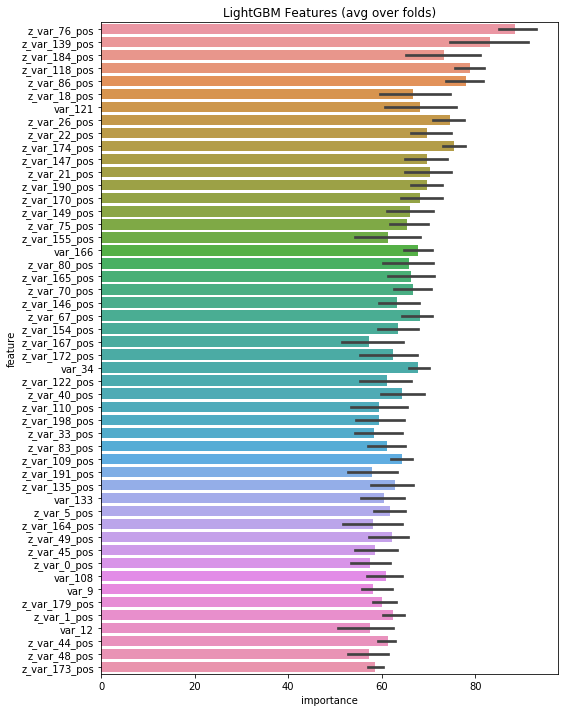

In [11]:
clfs = []
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
oof_preds = np.zeros((len(train_df), 1))
test_preds = np.zeros((len(test_df), 1))


X = train_df[feats]
y = train_df['target']
X_test = test_df[feats]
test_ids = test_df.ID_code.values
X['target'] = train_df['target']

parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    #'scale_pos_weight': 400,
    #'device' : 'gpu' ,
    'boosting': 'gbdt',
    'num_leaves': 4, #31
    'feature_fraction': 0.3,
    'bagging_fraction': 0.67,
    'bagging_freq': 5,
    'learning_rate': 0.05, #0.05
    'verbose': 30
    #'min_data_in_leaf': 50,
    #"max_depth" : -1,
#     'lambda_l1':2,
#     'lambda_l2':2
}

feature_importance_df = pd.DataFrame()
for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
    print("Current Fold: {}".format(fold_+1))
    trn_x, trn_y = X.iloc[trn_, :], y[trn_]
    val_x, val_y = X.iloc[val_, :], y[val_]
    
    #trn_x, trn_y = augmentation(trn_x,trn_y,5)
    
    z_pos_cols = []
    z_neg_cols = []
    z_diff_cols = []
    freq_cols = []
    
    for var in var_list:
        
        pos_mean = trn_x.loc[trn_x.target==1, var].median()
        pos_std = trn_x.loc[trn_x.target==1, var].std()
        neg_mean = trn_x.loc[trn_x.target==0, var].median()
        neg_std = trn_x.loc[trn_x.target==0, var].std()        

        
        #positive samples
        
        trn_x[f'z_{var}_pos'] = (trn_x[var] - pos_mean)/(pos_std/(trn_x[f'{var}_freq'].apply(lambda x: math.sqrt(x))))
        val_x[f'z_{var}_pos'] = (val_x[var] - pos_mean)/(pos_std/(val_x[f'{var}_freq'].apply(lambda x: math.sqrt(x))))
        X_test[f'z_{var}_pos'] = (X_test[var] - pos_mean)/(pos_std/(X_test[f'{var}_freq'].apply(lambda x: math.sqrt(x))))

#         trn_x[f'z_{var}_neg'] = (trn_x[var] - neg_mean)/(neg_std/(trn_x[f'{var}_freq'].apply(lambda x: math.sqrt(x))))
#         val_x[f'z_{var}_neg'] = (val_x[var] - neg_mean)/(neg_std/(val_x[f'{var}_freq'].apply(lambda x: math.sqrt(x))))
#         X_test[f'z_{var}_neg'] = (X_test[var] - neg_mean)/(neg_std/(X_test[f'{var}_freq'].apply(lambda x: math.sqrt(x))))
        
#         trn_x[f'z_{var}_over'] = trn_x[f'z_{var}_pos']/trn_x[f'z_{var}_neg']
#         val_x[f'z_{var}_over'] = val_x[f'z_{var}_pos']/val_x[f'z_{var}_neg']
#         X_test[f'z_{var}_over'] = val_x[f'z_{var}_pos']/val_x[f'z_{var}_neg']
        
        z_pos_cols.append(f'z_{var}_pos')
        z_neg_cols.append(f'z_{var}_neg')
        z_diff_cols.append(f'z_{var}_over')
        freq_cols.append(f'{var}_freq')

    trn_x['z_mean'] = trn_x[z_pos_cols].mean(1)
    trn_x['z_std'] = trn_x[z_pos_cols].std(1)
    trn_x['z_sum'] = trn_x[z_pos_cols].sum(1)
    trn_x['z_max'] = trn_x[z_pos_cols].max(1)
    trn_x['z_min'] = trn_x[z_pos_cols].min(1)
    trn_x['z_skew'] = trn_x[z_pos_cols].skew(1)
    
    val_x['z_mean'] = val_x[z_pos_cols].mean(1)
    val_x['z_std'] = val_x[z_pos_cols].std(1)
    val_x['z_sum'] = val_x[z_pos_cols].sum(1)
    val_x['z_max'] = val_x[z_pos_cols].max(1)
    val_x['z_min'] = val_x[z_pos_cols].min(1)
    val_x['z_skew'] = val_x[z_pos_cols].skew(1)
    
    X_test['z_mean'] = X_test[z_pos_cols].mean(1)
    X_test['z_std'] = X_test[z_pos_cols].std(1)
    X_test['z_sum'] = X_test[z_pos_cols].sum(1)
    X_test['z_max'] = X_test[z_pos_cols].max(1)
    X_test['z_min'] = X_test[z_pos_cols].min(1)
    X_test['z_skew'] = X_test[z_pos_cols].skew(1)
    
    
    exclusion = ['ID_code', 'target'] + z_neg_cols + freq_cols + z_diff_cols
    
    # for var in tqdm(var_list):
    #     exclusion.append('frequency_{}'.format(var))
    #     exclusion.append('prob_{}'.format(var))
    #     exclusion.append('true_prob_{}'.format(var))

    feats = [c for c in trn_x.columns if c not in exclusion]



    trn_lgb = lgb.Dataset(trn_x[feats], trn_y)
    val_lgb = lgb.Dataset(val_x[feats], val_y)
    clf = lgb.train(parameters,
                     train_set=trn_lgb,
                     #valid_sets=[valid_data_lgb,holdout_data_lgb],
                     valid_sets=[trn_lgb, val_lgb],
                     num_boost_round=30000,
                     early_stopping_rounds=500,
                     verbose_eval=500)
    


    val_pred = clf.predict(val_x[feats])
    test_fold_pred = clf.predict(X_test[feats])

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
   # print('getting feature importance')
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
test_preds /= n_folds
roc_score = roc_auc_score(y, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))


print("Saving submission file")
sample = pd.read_csv('../data/sample_submission.csv')
sample.target = test_preds.astype(float)
sample.ID_code = test_ids
sample.to_csv('../submissions/{}_{}.csv'.format(model_name,str(roc_score)), index=False)

display_importances(feature_importance_df)


In [ ]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

In [ ]:


shutil.copyfile(os.path.basename(NOTEBOOK_FULL_PATH), 
                             '../models/{}_{}.ipynb'.format(model_name, str(roc_score)))


In [ ]:
# train_df = pd.read_csv('../data/train.csv')
# test_df = pd.read_csv('../data/test.csv')

# var_list = [f for f in train_df.columns if 'var' in f]

# freq_cols = [f +'_freq' for f in var_list]

# test_df[freq_cols] = test_df[var_list].apply(lambda x: x.map(x.value_counts()))
# train_df[freq_cols] = train_df[var_list].apply(lambda x: x.map(x.value_counts()))

# test_df['min_freq'] = test_df[freq_cols].min(1)
# train_df['min_freq'] = train_df[freq_cols].min(1)


# real_test = test_df.loc[test_df.min_freq==1].copy()
# fake_test = test_df.loc[test_df.min_freq!=1].copy()

# all_real_df = pd.concat([train_df, real_test],sort=False)
# all_real_df[freq_cols] = all_real_df[var_list].apply(lambda x: x.map(x.value_counts()))

# train_df = all_real_df.loc[~all_real_df.target.isna()]
# real_test = all_real_df.loc[all_real_df.target.isna()]

# test_df = pd.concat([real_test, fake_test],sort=False)
# test_df.sort_index(inplace=True)


# train_df.to_pickle('../data/train_df.pkl')
# test_df.to_pickle('../data/test_df.pkl')